# Remote Fire Risk Assessment
## Classifying Remote Sensing Images for Fire Risk Level
### Kori Thompson
In recent decades wildfires have become increasingly destructive natural disasters that have resulted in massive property damage, injuries, and fatalities. These disasters have also wreaked havoc on forest ecosystems. To mitigate these consequences, it is imperative to prevent wildfires. One key step in preventing wildfires is to identify wildfire hazards and risks as much as possible. This allows for the proper responses to be taken to reduce these risks. Fire risk assessments are time-consuming processes that require both the identification and evaluation of the potential risks. While methods using satellite data such as surface temperature, moisture levels, and other geoscientific data exist, these still require specialized knowledge. Introducing remote sensing imagery and satellite imagery into the field can help in mapping geographical features to these measurements and reduce the specialized knowledge bottleneck.

This analysis seeks to examine whether remote sensing imagery can be used to classify land areas into fire risk levels. The FireRisk dataset, a collection of remote sensing imagery of different classifications of wildfire risks, was used for the analysis. By utilizing computer vision techniques rather than other machine learning methods, it may be possible to create a simplified method for assessing fire risks. Due to the image resolutions and the amount of detail captured in the remote sensing imagery, deep learning models, in particular convolutional neural networks (CNN) can be of use. CNNs allow the model to learn features from raw pixel data unlike other machine learning models. These models can extract patterns from the pixel data which can be recognized anywhere in the image, allowing for greater ability to classify images. These models require less interpretation and less specialized knowledge than other machine learning models, making them more streamlined.

In [ ]:
# file processing
import os, pathlib, natsort, shutil, glob
# data processing
import numpy as np

# data visualizaiton
import matplotlib.pyplot as plt

# modeling and model tuning
import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras_tuner as kt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip -d  ./ ./drive/MyDrive/FireRisk.zip

Streaming output truncated to the last 5000 lines.
  inflating: ./FireRisk/val/Very_Low/35634611_1_-96.3903554291513_43.1390592690867.png  
  inflating: ./FireRisk/val/Very_Low/37235331_1_-102.18102746194_42.7419062384177.png  
  inflating: ./FireRisk/val/Very_Low/35832721_1_-105.188831669713_42.7850177745744.png  
  inflating: ./FireRisk/val/Very_Low/35741751_1_-99.560721807133_43.0743463408639.png  
  inflating: ./FireRisk/val/Very_Low/37125221_1_-111.097181337422_42.0249195540572.png  
  inflating: ./FireRisk/val/Very_Low/36479851_1_-109.941558776589_42.258132078111.png  
  inflating: ./FireRisk/val/Very_Low/36978151_1_-89.7987444984509_42.7821062755204.png  
  inflating: ./FireRisk/val/Very_Low/35523401_1_-106.884850389277_42.7026631814055.png  
  inflating: ./FireRisk/val/Very_Low/37928551_1_-91.3570584251029_42.6968929601469.png  
  inflating: ./FireRisk/val/Very_Low/36511311_1_-107.881433957583_42.4594112284843.png  
  inflating: ./FireRisk/val/Very_Low/37463801_1_-107.201178271

# Data
The dataset used for this analysis is the FireRisk dataset from Shuchang Shen and Sachith Seneviratne and Xinye Wanyan and Michael Kirley. It was proposed as a benchmark dataset for remote fire risk assessment. The dataset consisted of 91,872 labeled high-resolution remote sensing images collected using the National Agriculture Imagery Program (NAIP). Images were labeled using with the fire risk classes supplied by the Wildfire Hazard Potential (WHP) raster dataset. The 7 classes fire risk classes are: water, non-burnable, very low, low, moderate, high, and very high risk. The dataset was pre-split into training and validation datasets with 70,331 images in the training split and 21,541 images in the validation split.



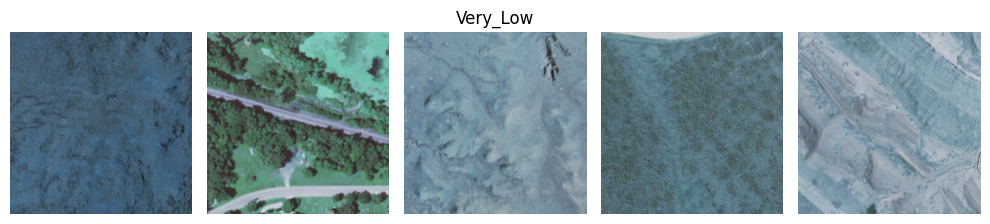

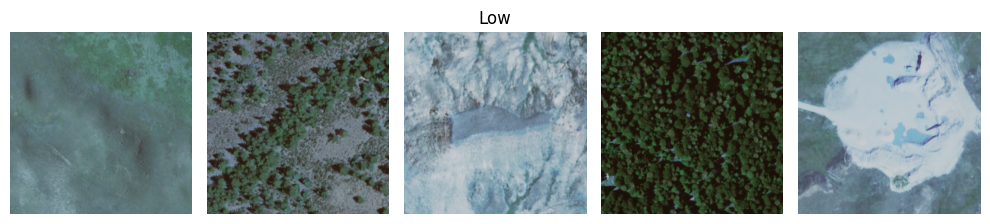

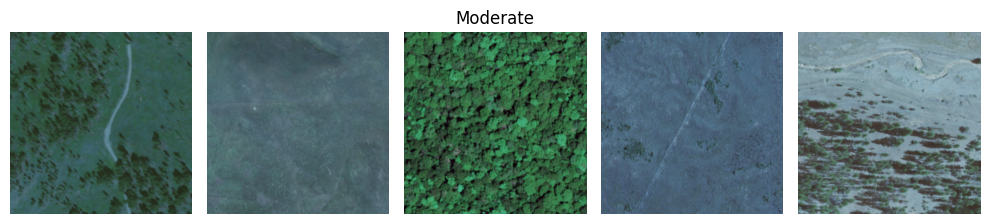

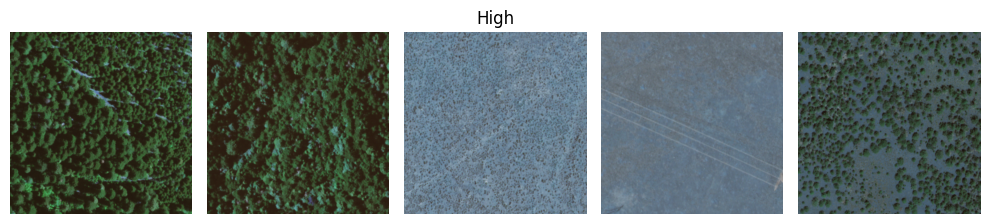

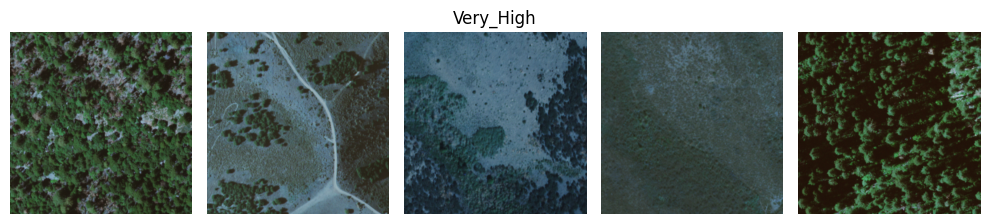

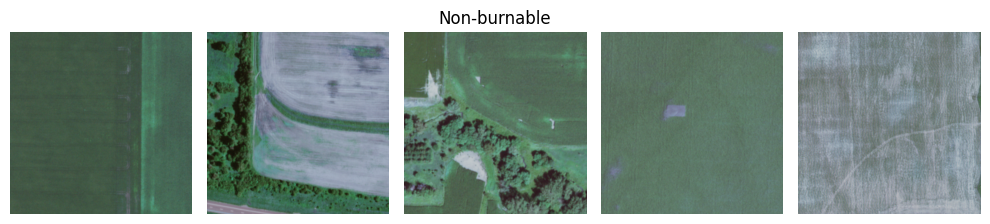

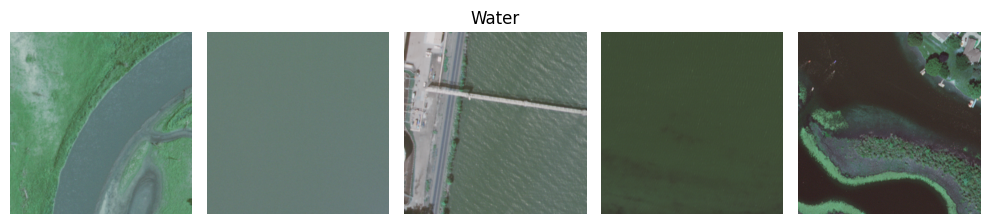

In [ ]:
import cv2
import random
random.seed(303)
folders = ['Very_Low','Low','Moderate','High','Very_High','Non-burnable','Water']

for folder in folders:
        folder_path = os.path.join('./FireRisk/train', folder)
        images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        images = random.sample(images,5)
        fig, axes = plt.subplots(1, 5, figsize=(10, 5))

        for i in range(5):
            image_path = os.path.join(folder_path, images[i])
            try:
                img = cv2.imread(image_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axes[i].imshow(img)
                axes[i].axis('off')
                if i == 2:
                    axes[i].set_title(f"{folder}")
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
                axes[i].axis('off')

        plt.tight_layout()
        plt.show()


Some of the classes appear to share farily similar looking images which may affect the ability of the model to correctly identify these classes. This can especially be seen with the moderate, high, and very high risk images. All three classes have very sparsely forested areas that appear very dry and images that are densely forested. The images from the water class are highly distinctive and will likely be easily identified from the other images.

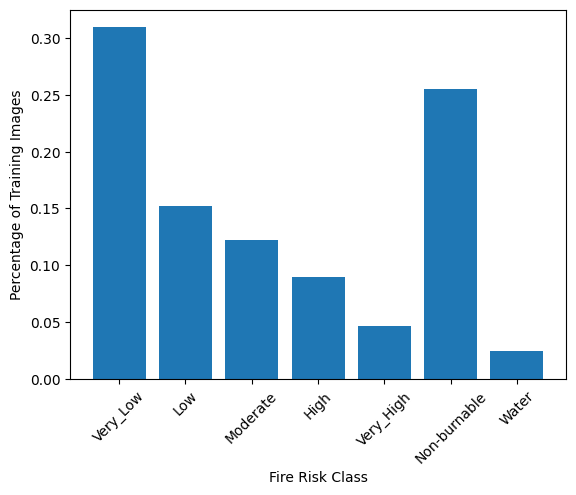

In [ ]:
folders = ['Very_Low','Low','Moderate','High','Very_High','Non-burnable','Water']
counts = []
for folder in folders:
        folder_path = os.path.join('./FireRisk/train/', folder)
        counts.append(len(os.listdir(folder_path)))
percents = []
for count in counts:
    percents.append(count/sum(counts))
plt.bar(x=folders, height=percents)
plt.xticks(rotation=45)
plt.ylabel('Percentage of Training Images')
plt.xlabel('Fire Risk Class')
plt.show()

Classes are imbalanced with more images of the very low risk class than any other class. Approximately 31% of all the training images were from the very low fire risk class and 25% are of the non-burnable class. 15% of the images were from the low fire risk class, 4.6% from the very high fire risk class, 12% from the moderate fire risk class, 9% from the high fire risk class, and 2.4% from the water class. There is a high bias toward very low fire risk classes, most likely because there were few moderate to high risk instances observed.

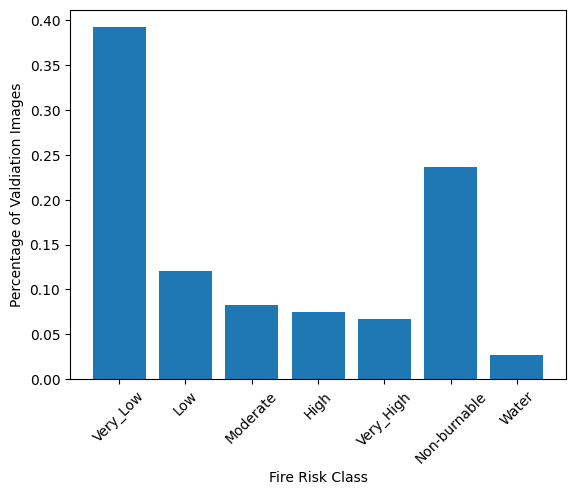

In [ ]:
val_counts = []
for folder in folders:
        folder_path = os.path.join('./FireRisk/val/', folder)
        val_counts.append(len(os.listdir(folder_path)))

percents = []
for count in val_counts:
    percents.append(count/sum(val_counts))

plt.bar(x=folders, height=percents)
plt.xticks(rotation=45)
plt.ylabel('Percentage of Valdiation Images')
plt.xlabel('Fire Risk Class')
plt.show()

A similar trend is seen with the validation data. 39% of the validation images were from the very low fire risk class and 23.6% of the images are from the non-burnable class. 12% were from the low fire risk class, 6.8% from the very high fire risk class, 8.2% from the moderate fire risk class, 7.5% from the high fire risk class, and 2.7% from the water class. Again there is high bias toward the non-burnable and very low risk classes.

The training and valdiation datasets were created using the keras utility, image_dataset_from_directory. A batch size of 32 was used for both the training and validation dataset. The images in each dataset were randomly shuffled to ensure each batch received a mix of classes. The images were all changed, if needed, to an image size of 256x256 pixels, before being converted to arrays of pixel values.

In [ ]:
train = keras.utils.image_dataset_from_directory(
    './FireRisk/train',
    shuffle=True,
    image_size=(256, 256),
    label_mode = 'categorical',
    batch_size=32)

validation = keras.utils.image_dataset_from_directory(
    './FireRisk/val',
    shuffle=True,
    image_size=(256, 256),
    label_mode = 'categorical',
    batch_size=32)


Found 70331 files belonging to 7 classes.
Found 21541 files belonging to 7 classes.


No image augmentation was done on the datasets. Since both datasets were already fairly large, adding image augmentation would have expanded the datasets too much. This would have made the datasets unweildy for computing resources available for this analysis.

In [ ]:
total = sum(counts)
weights = {}
label_order = ['High', 'Low', 'Moderate', 'Non-burnable', 'Very_High', 'Very_Low', 'Water']
for i in range(len(counts)):
    weights[folders[i]] = (1/counts[i]) * (total/len(folders))


class_weights = {}
for i in range(len(label_order)):
  class_weights[i] = weights[label_order[i]]

# Baseline Models
Three models were constructed as baseline models. The first model used a pre-trained ResNet50 base. The second model used a pre-trained InceptionResNetV2 base. The third baseline model used a pretrained EfficientNetV2S base. All models used the re-determined weights from training the models on the ImageNet dataset. The top layers of the models were not used for the baseline, only the convolutional layers were. After the pre-trained base, a global average pooling layer was used to flatten the input to one dimension. This was followed by a dropout layer with a dropout rate of 0.2, a fully connected layer with 1024 nodes, and another dropout layer. A fully connect layer with 7 nodes and a softmax activation was used to predict the class of the image. The models were each trained for 15 epochs and evaluated on validation loss and validation accuracy.


In [ ]:
conv_base = keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
conv_base.trainable = False

inputs = keras.Input(shape=(256, 256, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(7, activation='softmax')(x)

model = keras.Model(inputs, outputs, name='baseline_1')
model.summary()

Model: "baseline_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_9 (GetItem)      │ (None, 256, 256)       │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_10 (GetItem)     │ (None, 256, 256)       │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_11 (GetItem)     │ (None, 256, 256)       │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_4 (Stack)           │ (None, 256, 256, 3)    │              0 │ get_item_9[0][0],      │
│                           │                        │                │ get_item_10[0][0],     │
│                           │                        │                │ get_item_11[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 256, 256, 3)    │              0 │ stack_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 8, 8, 2048)     │     23,587,712 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 2048)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 1024)           │      2,098,176 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 1024)           │              0 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 7)              │          7,175 │ dropout_7[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 25,693,063 (98.01 MB)

 Trainable params: 2,105,351 (8.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = keras.callbacks.ModelCheckpoint(
    filepath='./baseline1.keras',
    save_best_only=True,
    monitor='val_loss')


history = model.fit(train,
                    epochs=15,
                    validation_data=validation,
                    callbacks=callbacks)

Epoch 1/15
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 501s 223ms/step - accuracy: 0.5066 - loss: 1.3352 - val_accuracy: 0.5667 - val_loss: 1.1128
Epoch 2/15
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 498s 227ms/step - accuracy: 0.5505 - loss: 1.1457 - val_accuracy: 0.5773 - val_loss: 1.1452
Epoch 3/15
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 495s 225ms/step - accuracy: 0.5568 - loss: 1.1477 - val_accuracy: 0.5607 - val_loss: 1.1372
Epoch 4/15
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 501s 225ms/step - accuracy: 0.5595 - loss: 1.1397 - val_accuracy: 0.5683 - val_loss: 1.1812
Epoch 5/15
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 500s 227ms/step - accuracy: 0.5651 - loss: 1.1443 - val_accuracy: 0.5539 - val_loss: 1.2038
Epoch 6/15
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 445s 203ms/step - accuracy: 0.5638 - loss: 1.1511 - val_accuracy: 0.5633 - val_loss: 1.1883
Epoch 7/15
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 489s 223ms/step - accuracy: 0.5695 - loss: 1.1509 - val_accuracy: 0.5778 - val_loss: 1.1851
Epoch 8/15
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 506s 224ms/step - ac

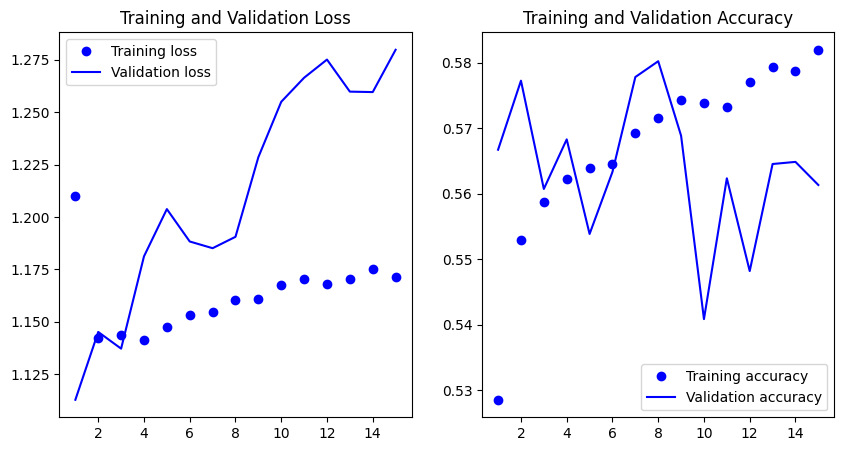

In [ ]:
epochs = range(1, len(history.history['loss']) + 1)

fig, ax = plt.subplots(1,2, figsize=(10,5))


ax[0].plot(epochs, history.history['loss'], 'bo', label='Training loss')
ax[0].plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
ax[0].set_title('Training and Validation Loss')
ax[0].legend()
ax[1].plot(epochs, history.history['accuracy'], 'bo', label='Training accuracy')
ax[1].plot(epochs, history.history['val_accuracy'], 'b', label='Validation accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].legend()
plt.show()

Validation accuracy started higher than training accuracy before peaking and begining to decrease. The model may have begun to peak around the eight epoch where the validation accuracy peaked and the validation loss noticably began to increse. Overall the model achieved fairly low accuracy, with it's validation accuracy peaking at 0.5802. Both the validation loss and and validation accuracy fluxuated quite a bit a bit without having smooth rate of increase or decrease. This may imply that the model is not generalizing as well to validation data and may require stronger regularization.

In [ ]:
conv_base = keras.applications.InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
conv_base.trainable = False

inputs = keras.Input(shape=(256, 256, 3))
x = keras.applications.inception_v3.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(7, activation='softmax')(x)

model = keras.Model(inputs, outputs, name='baseline_2')
model.summary()

Model: "baseline_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide_3 (TrueDivide)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract_3 (Subtract)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_resnet_v2 (Functional)     │ (None, 6, 6, 1536)          │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1024)                │       1,573,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 7)                   │           7,175 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,917,799 (213.31 MB)

 Trainable params: 1,581,063 (6.03 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [ ]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = keras.callbacks.ModelCheckpoint(
    filepath='./baseline2.keras',
    save_best_only=True,
    monitor='val_loss')


history1 = model.fit(train,
                    epochs=15,
                    validation_data=validation,
                    callbacks=callbacks)

Epoch 1/15
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 654s 283ms/step - accuracy: 0.4699 - loss: 1.4420 - val_accuracy: 0.5516 - val_loss: 1.1887
Epoch 2/15
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 632s 266ms/step - accuracy: 0.5191 - loss: 1.2190 - val_accuracy: 0.5616 - val_loss: 1.2117
Epoch 3/15
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 628s 269ms/step - accuracy: 0.5235 - loss: 1.2128 - val_accuracy: 0.5641 - val_loss: 1.1716
Epoch 4/15
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 618s 267ms/step - accuracy: 0.5287 - loss: 1.2075 - val_accuracy: 0.5702 - val_loss: 1.1879
Epoch 5/15
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 628s 269ms/step - accuracy: 0.5296 - loss: 1.2091 - val_accuracy: 0.5591 - val_loss: 1.1937
Epoch 6/15
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 616s 266ms/step - accuracy: 0.5316 - loss: 1.2094 - val_accuracy: 0.5641 - val_loss: 1.2094
Epoch 7/15
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 618s 264ms/step - accuracy: 0.5325 - loss: 1.2169 - val_accuracy: 0.5448 - val_loss: 1.2735
Epoch 8/15
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 577s 263ms/step - ac

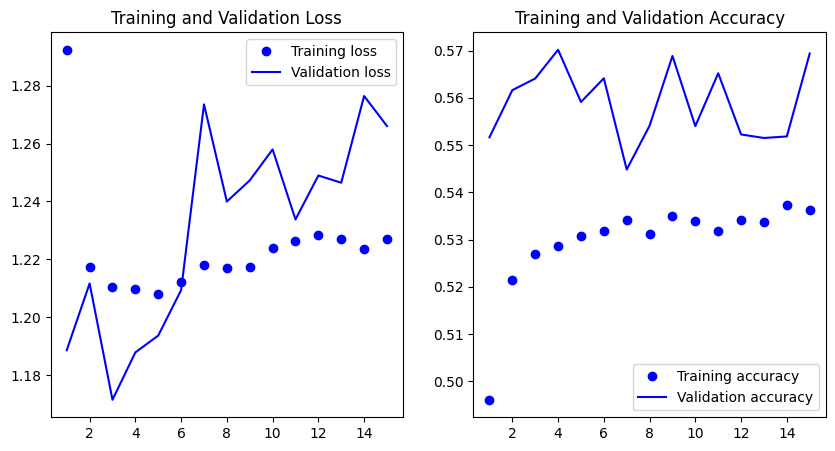

In [ ]:
epochs = range(1, len(history1.history['loss']) + 1)

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(epochs, history1.history['loss'], 'bo', label='Training loss')
ax[0].plot(epochs, history1.history['val_loss'], 'b', label='Validation loss')
ax[0].set_title('Training and Validation Loss')
ax[0].legend()
ax[1].plot(epochs, history1.history['accuracy'], 'bo', label='Training accuracy')
ax[1].plot(epochs, history1.history['val_accuracy'], 'b', label='Validation accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].legend()
plt.show()

Validation loss and validation accuracy outperformed the training loss and accuracy for nearly all epochs. Much like the prior model, the validation loss and validation accuracy flucuate without having a smooth increase or decrease. This may imply that the model is not generalizing as well to validation data despite the better performance of the validation data. The model's validation accuracy peaked at 0.5702, implying that the model began overfitting around the fourth epoch.

In [ ]:
conv_base = keras.applications.EfficientNetV2S(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
conv_base.trainable = False

inputs = keras.Input(shape=(256, 256, 3))
x = keras.applications.efficientnet_v2.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(7, activation='softmax')(x)

model = keras.Model(inputs, outputs, name='baseline_3')
model.summary()

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "baseline_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)          │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-s (Functional)        │ (None, 8, 8, 1280)          │      20,331,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1024)                │       1,311,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 7)                   │           7,175 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,650,279 (82.59 MB)

 Trainable params: 1,318,919 (5.03 MB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [ ]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = keras.callbacks.ModelCheckpoint(
    filepath='./baseline3.keras',
    save_best_only=True,
    monitor='val_loss')


history2 = model.fit(train,
                    epochs=15,
                    validation_data=validation,
                    callbacks=callbacks)

Epoch 1/15
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 601s 247ms/step - accuracy: 0.5111 - loss: 1.2462 - val_accuracy: 0.5702 - val_loss: 1.1288
Epoch 2/15
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 555s 232ms/step - accuracy: 0.5480 - loss: 1.1641 - val_accuracy: 0.5782 - val_loss: 1.1382
Epoch 3/15
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 478s 217ms/step - accuracy: 0.5526 - loss: 1.1553 - val_accuracy: 0.5730 - val_loss: 1.1610
Epoch 4/15
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 509s 232ms/step - accuracy: 0.5550 - loss: 1.1581 - val_accuracy: 0.5718 - val_loss: 1.1752
Epoch 5/15
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 523s 214ms/step - accuracy: 0.5613 - loss: 1.1528 - val_accuracy: 0.5665 - val_loss: 1.1848
Epoch 6/15
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 505s 230ms/step - accuracy: 0.5639 - loss: 1.1531 - val_accuracy: 0.5708 - val_loss: 1.1907
Epoch 7/15
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 568s 233ms/step - accuracy: 0.5664 - loss: 1.1514 - val_accuracy: 0.5592 - val_loss: 1.2123
Epoch 8/15
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 493s 224ms/step - ac

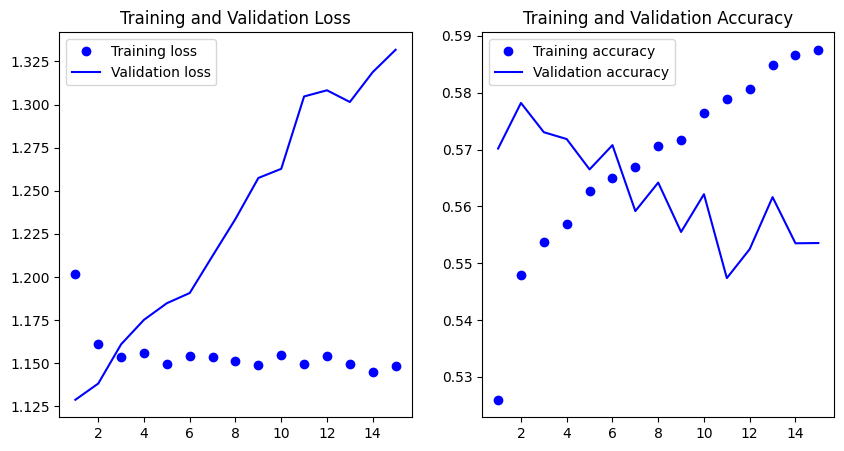

In [ ]:
epochs = range(1, len(history2.history['loss']) + 1)

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(epochs, history2.history['loss'], 'bo', label='Training loss')
ax[0].plot(epochs, history2.history['val_loss'], 'b', label='Validation loss')
ax[0].set_title('Training and Validation Loss')
ax[0].legend()
ax[1].plot(epochs, history2.history['accuracy'], 'bo', label='Training accuracy')
ax[1].plot(epochs, history2.history['val_accuracy'], 'b', label='Validation accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].legend()
plt.show()

As with the prior baseline model, the validation loss was lower than the training loss and the validation accuracy was higher than the training accuracy. Unlike the other models, this model had less severe flucuations in validation loss and a validation accuracy. The model performed better than the second baseline, achieving a peak validation accuracy of 0.5782, but worse than the ResNet50 model. It appears to have overfit fairly quickly into training as validation loss continued to increase during training rather than decreasing.

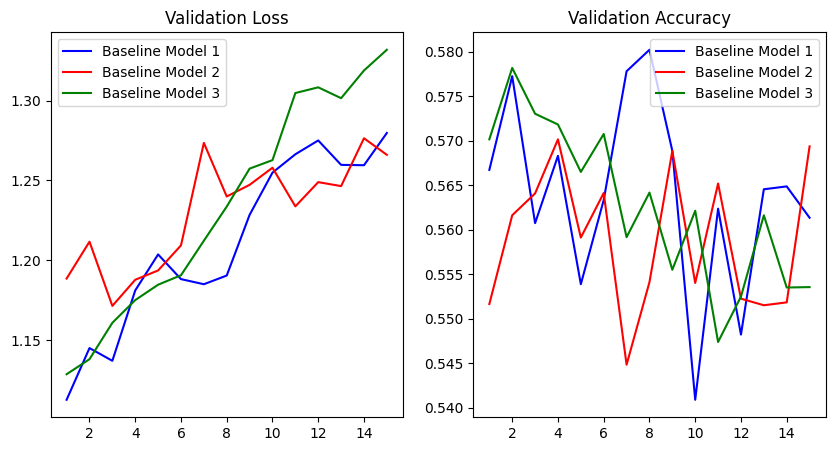

In [ ]:
epochs = range(1, len(history2.history['loss']) + 1)
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(epochs, history.history['val_loss'], color='blue', label='Baseline Model 1')
ax[0].plot(epochs, history1.history['val_loss'], color='red', label='Baseline Model 2')
ax[0].plot(epochs, history2.history['val_loss'], color='green', label='Baseline Model 3')
ax[0].set_title('Validation Loss')
ax[0].legend()

ax[1].plot(epochs, history.history['val_accuracy'], color='blue', label='Baseline Model 1')
ax[1].plot(epochs, history1.history['val_accuracy'], color='red', label='Baseline Model 2')
ax[1].plot(epochs, history2.history['val_accuracy'], color='green', label='Baseline Model 3')
ax[1].set_title('Validation Accuracy')
plt.legend()
plt.show()

The best performing model in terms of both validaiton loss and validation accuracy was the first baseline model. It achieved the highest validation accuracy of any of the models and generally had a smaller validation loss compared to the other baseline models.

## Buidling the Model
As the baseline model with the best validation accuracy and lowest validation loss, the first baseline model using the ResNet50 base was chosen as the base for the final model. With the validation loss and validation accuracy usually out performing the training loss and accuracy, one possible reason is that the model may be undercapacity. Additional layers were added to increase the capacity of the network, by two and three layers. Finally a test was conducted using no dropout layers.

A network with two fully connected layers performed best on both validation accuracy and validation loss. Using no dropout layers with the two fully connected resulted in both the highest validation accuracy and lowest validation loss of any architecture tested. However, the lowest validation loss occured in the first epoch with validation loss continuing to increase in all following epochs. This implies the model may have been overfitting from the beginning. Due to this, it was decided to leave the dropout layers in the network.

In [ ]:
conv_base = keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
conv_base.trainable = False

In [ ]:
inputs = keras.Input(shape=(256, 256, 3))
x = keras.applications.resnet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(7, activation='softmax')(x)

model = keras.Model(inputs, outputs, name='more_layers')
model.summary()

Model: "more_layers"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_12 (GetItem)     │ (None, 256, 256)       │              0 │ input_layer_19[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_13 (GetItem)     │ (None, 256, 256)       │              0 │ input_layer_19[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_14 (GetItem)     │ (None, 256, 256)       │              0 │ input_layer_19[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_4 (Stack)           │ (None, 256, 256, 3)    │              0 │ get_item_12[0][0],     │
│                           │                        │                │ get_item_13[0][0],     │
│                           │                        │                │ get_item_14[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 256, 256, 3)    │              0 │ stack_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 8, 8, 2048)     │     23,587,712 │ add_4[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 2048)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 1024)           │      2,098,176 │ dropout_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 1024)           │              0 │ dense_14[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 1024)           │      1,049,600 │ dropout_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_15 (Dropout)      │ (None, 1024)           │              0 │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 7)              │          7,175 │ dropout_15[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 26,742,663 (102.02 MB)

 Trainable params: 3,154,951 (12.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = keras.callbacks.ModelCheckpoint(
    filepath='./more_layers.keras',
    save_best_only=True,
    monitor='val_loss')


model.fit(train,
          epochs=10,
          validation_data=validation,
          callbacks=callbacks)

Epoch 1/10
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 532s 234ms/step - accuracy: 0.5033 - loss: 1.3100 - val_accuracy: 0.5728 - val_loss: 1.1622
Epoch 2/10
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 474s 216ms/step - accuracy: 0.5413 - loss: 1.1710 - val_accuracy: 0.5760 - val_loss: 1.1140
Epoch 3/10
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 501s 228ms/step - accuracy: 0.5466 - loss: 1.1665 - val_accuracy: 0.5877 - val_loss: 1.1164
Epoch 4/10
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 464s 211ms/step - accuracy: 0.5475 - loss: 1.1664 - val_accuracy: 0.5926 - val_loss: 1.0999
Epoch 5/10
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 508s 214ms/step - accuracy: 0.5520 - loss: 1.1700 - val_accuracy: 0.5922 - val_loss: 1.1064
Epoch 6/10
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 462s 210ms/step - accuracy: 0.5539 - loss: 1.1706 - val_accuracy: 0.5970 - val_loss: 1.1113
Epoch 7/10
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 468s 213ms/step - accuracy: 0.5534 - loss: 1.1875 - val_accuracy: 0.5928 - val_loss: 1.1163
Epoch 8/10
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 538s 230ms/step - ac

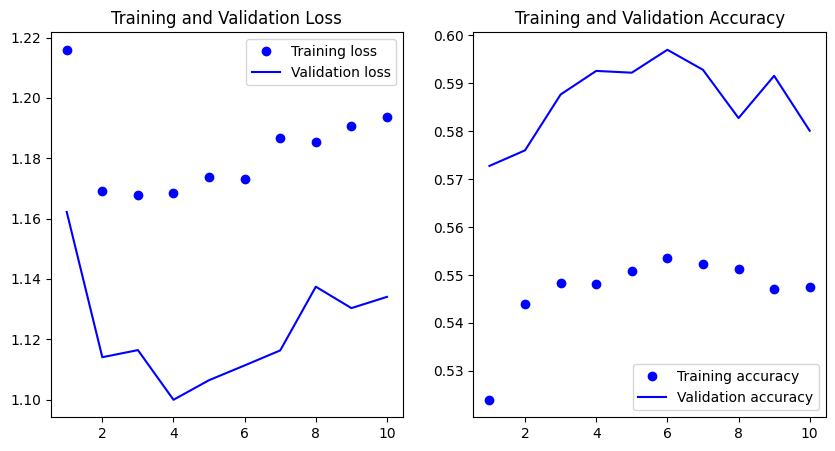

In [ ]:
history3 = model.history

epochs = range(1, len(history3.history['loss']) + 1)
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(epochs, history3.history['loss'], 'bo', label='Training loss')
ax[0].plot(epochs, history3.history['val_loss'], 'b', label='Validation loss')
ax[0].set_title('Training and Validation Loss')
ax[0].legend()
ax[1].plot(epochs, history3.history['accuracy'], 'bo', label='Training accuracy')
ax[1].plot(epochs, history3.history['val_accuracy'], 'b', label='Validation accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].legend()
plt.show()

Validation loss and accuracy outperformed the training for all epochs. The model appears to have begun overfitting at around the fourth epoch, where validation loss bottoms outs before increasing. Validation accuracy peaked around the sixth epoch at 59.7%. This is an improvement on the performance of the base model which achieved a validation accuracy of 58.02%.

In [ ]:
inputs = keras.Input(shape=(256, 256, 3))
x = keras.applications.resnet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(7, activation='softmax')(x)

model = keras.Model(inputs, outputs, name='more_layers2')
model.summary()

Model: "more_layers2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_24 (GetItem)     │ (None, 256, 256)       │              0 │ input_layer_23[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_25 (GetItem)     │ (None, 256, 256)       │              0 │ input_layer_23[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_26 (GetItem)     │ (None, 256, 256)       │              0 │ input_layer_23[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_8 (Stack)           │ (None, 256, 256, 3)    │              0 │ get_item_24[0][0],     │
│                           │                        │                │ get_item_25[0][0],     │
│                           │                        │                │ get_item_26[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 256, 256, 3)    │              0 │ stack_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 8, 8, 2048)     │     23,587,712 │ add_8[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[3][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 2048)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 1024)           │      2,098,176 │ dropout_21[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_22 (Dropout)      │ (None, 1024)           │              0 │ dense_22[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 1024)           │      1,049,600 │ dropout_22[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_23 (Dropout)      │ (None, 1024)           │              0 │ dense_23[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_24 (Dense)          │ (None, 1024)           │      1,049,600 │ dropout_23[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_24 (Dropout)      │ (None, 1024)           │              0 │ dense_24[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_25 (Dense)          │ (None, 7)              │          7,175 │ dropout_24[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 27,792,263 (106.02 MB)

 Trainable params: 4,204,551 (16.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = keras.callbacks.ModelCheckpoint(
    filepath='./more_layers2.keras',
    save_best_only=True,
    monitor='val_loss')


history4 = model.fit(train,
                    epochs=10,
                    validation_data=validation,
                    callbacks=callbacks)

Epoch 1/10
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 544s 241ms/step - accuracy: 0.4989 - loss: 1.3327 - val_accuracy: 0.5656 - val_loss: 1.1687
Epoch 2/10
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 493s 213ms/step - accuracy: 0.5395 - loss: 1.1761 - val_accuracy: 0.5743 - val_loss: 1.1393
Epoch 3/10
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 470s 214ms/step - accuracy: 0.5454 - loss: 1.1735 - val_accuracy: 0.5656 - val_loss: 1.1237
Epoch 4/10
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 508s 231ms/step - accuracy: 0.5481 - loss: 1.1738 - val_accuracy: 0.5855 - val_loss: 1.1197
Epoch 5/10
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 557s 229ms/step - accuracy: 0.5515 - loss: 1.1682 - val_accuracy: 0.5850 - val_loss: 1.1299
Epoch 6/10
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 531s 215ms/step - accuracy: 0.5519 - loss: 1.1707 - val_accuracy: 0.5963 - val_loss: 1.1239
Epoch 7/10
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 504s 216ms/step - accuracy: 0.5561 - loss: 1.1666 - val_accuracy: 0.5882 - val_loss: 1.1270
Epoch 8/10
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 491s 211ms/step - ac

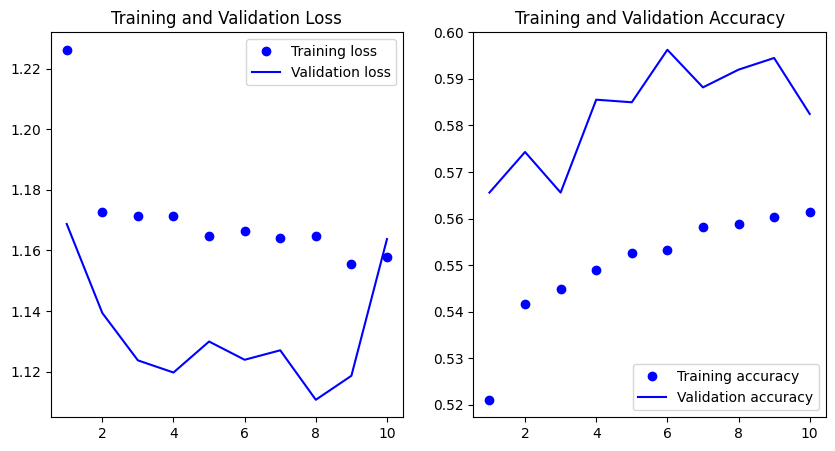

In [ ]:
epochs = range(1, len(history4.history['loss']) + 1)
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(epochs, history4.history['loss'], 'bo', label='Training loss')
ax[0].plot(epochs, history4.history['val_loss'], 'b', label='Validation loss')
ax[0].set_title('Training and Validation Loss')
ax[0].legend()
ax[1].plot(epochs, history4.history['accuracy'], 'bo', label='Training accuracy')
ax[1].plot(epochs, history4.history['val_accuracy'], 'b', label='Validation accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].legend()
plt.show()

Much like the other model, the validation accuracy and validation loss were significantly better than their training counterparts. The model performed comparably with the the two layer model, but did achieve a lower maximum valdiation accuracy. Similarly, it had a higher minimum validation loss than the two layer model. For this reason, only two fully connected layers were used moving forward.

In [ ]:
inputs = keras.Input(shape=(256, 256, 3))
x = keras.applications.resnet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)
outputs = layers.Dense(7, activation='softmax')(x)

model = keras.Model(inputs, outputs, name='no_dropout')
model.summary()

Model: "no_dropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None, 256, 256)       │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_4 (GetItem)      │ (None, 256, 256)       │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_5 (GetItem)      │ (None, 256, 256)       │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_2 (Stack)           │ (None, 256, 256, 3)    │              0 │ get_item_3[0][0],      │
│                           │                        │                │ get_item_4[0][0],      │
│                           │                        │                │ get_item_5[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 256, 256, 3)    │              0 │ stack_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 8, 8, 2048)     │     23,587,712 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[1][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 1024)           │      2,098,176 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1024)           │      1,049,600 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 7)              │          7,175 │ dense_4[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 26,742,663 (102.02 MB)

 Trainable params: 3,154,951 (12.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = keras.callbacks.ModelCheckpoint(
    filepath='./no_dropout.keras',
    save_best_only=True,
    monitor='val_loss')


history5 = model.fit(train,
                    epochs=10,
                    validation_data=validation,
                    callbacks=callbacks)

Epoch 1/10
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 292s 128ms/step - accuracy: 0.5203 - loss: 1.2833 - val_accuracy: 0.5897 - val_loss: 1.0687
Epoch 2/10
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 273s 124ms/step - accuracy: 0.5719 - loss: 1.0786 - val_accuracy: 0.5933 - val_loss: 1.0732
Epoch 3/10
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 273s 124ms/step - accuracy: 0.5821 - loss: 1.0528 - val_accuracy: 0.5885 - val_loss: 1.0936
Epoch 4/10
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 272s 124ms/step - accuracy: 0.5898 - loss: 1.0320 - val_accuracy: 0.5907 - val_loss: 1.1203
Epoch 5/10
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 272s 124ms/step - accuracy: 0.5980 - loss: 1.0165 - val_accuracy: 0.5988 - val_loss: 1.1047
Epoch 6/10
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 273s 124ms/step - accuracy: 0.6063 - loss: 1.0001 - val_accuracy: 0.5949 - val_loss: 1.1335
Epoch 7/10
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 273s 124ms/step - accuracy: 0.6130 - loss: 0.9840 - val_accuracy: 0.5540 - val_loss: 1.2188
Epoch 8/10
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 272s 124ms/step - ac

Removing the dropout layers proved to provide the best performance of all the models. It achieved the highest validation accuracy of 60.69%. However, the minimum validation loss was reached in the first epoch and steadly increased in all following epochs. This raised concerns that without the dropout layers the model may have been overfitting from the start. As such, the dropout layers were left in the model to help prevent overfitting.
# Fine-Tuning the Final Model
To fine-tune the final model, a hyperband search was used to find the best hyperparameters. Since the classes in the dataset are imbalanced the model was optimized for validation loss rather than validation accuracy. During the search the following hyperparameters were tuned: dropout rate, the number of neurons in each of the fully connected layers, and the learning rate used in the optimizer. The dropout rate was tuned to change the amount of regularization used in the model. The optimal dropout value was found to be... Each layer had its neurons tuned to find the best combination of neurons. The search space started at 512 and increased by 512 to 2,048 neurons. The idea was to find the number of neurons that minimized the loss of the model while preventing overfitting. Finally the learning rate was tuned to assist in the model converge on optimal values for weights.

In [ ]:
def build_model(hp):
  dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.05)
  units_1 = hp.Int('units_1', min_value=512, max_value=2048, step=512)
  units_2 = hp.Int('units_2', min_value=512, max_value=2048, step=512)
  lr = hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')

  conv_base = keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
  conv_base.trainable = False

  model = keras.Sequential()
  model.add(keras.Input(shape=(256, 256, 3)))
  model.add(conv_base)
  model.add(layers.GlobalAveragePooling2D())
  model.add(layers.Dropout(dropout))
  model.add(layers.Dense(units = units_1, activation='relu'))
  model.add(layers.Dropout(dropout))
  model.add(layers.Dense(units = units_2, activation='relu'))
  model.add(layers.Dropout(dropout))
  model.add(layers.Dense(7, activation='softmax'))

  model.compile(optimizer= keras.optimizers.RMSprop(learning_rate=lr),loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs = 25,
    hyperband_iterations=1,
    overwrite=True,
    directory='./',
    project_name='final_model'
)


callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]

tuner.search(
    train,
    epochs=25,
    validation_data=validation,
    callbacks = callbacks,
    verbose=2
)

Trial 22 Complete [01h 18m 12s]
val_loss: 1.1748418807983398

Best val_loss So Far: 1.0752462148666382
Total elapsed time: 16h 19m 36s

Search: Running Trial #23

Value             |Best Value So Far |Hyperparameter
0.45              |0.25              |dropout
512               |512               |units_1
512               |512               |units_2
0.00052922        |0.00028948        |lr
9                 |25                |tuner/epochs
0                 |9                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/9
2198/2198 - 531s - 242ms/step - accuracy: 0.5002 - loss: 1.2984 - val_accuracy: 0.5788 - val_loss: 1.1872
Epoch 2/9
2198/2198 - 555s - 253ms/step - accuracy: 0.5237 - loss: 1.2393 - val_accuracy: 0.5721 - val_loss: 1.1704
Epoch 3/9
2198/2198 - 559s - 254ms/step - accuracy: 0.5276 - loss: 1.2425 - val_accuracy: 0.5876 - val_loss: 1.1696
Epoch 4/9
2198/2198 - 511s - 233ms/step - acc

The computing resources were unable to handle the entire hyperband search. However, based on the results that were available, a dropout rate of 25%, 512 neurons in both of the fully connected layers, and a learning rate of 0.00028948 had the lowest validation loss.

In [ ]:
conv_base = keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
conv_base.trainable = False


inputs = keras.Input(shape=(256, 256, 3))
x = keras.applications.resnet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(units = 512, activation='relu')(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(units = 512, activation='relu')(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(7, activation='softmax')(x)

model = keras.Model(inputs, outputs, name='tuned_model')
model.summary()

model.compile(optimizer= keras.optimizers.RMSprop(learning_rate=0.00028948),loss='categorical_crossentropy', metrics=['accuracy'])

Model: "tuned_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_12 (GetItem)     │ (None, 256, 256)       │              0 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_13 (GetItem)     │ (None, 256, 256)       │              0 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_14 (GetItem)     │ (None, 256, 256)       │              0 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack_5 (Stack)           │ (None, 256, 256, 3)    │              0 │ get_item_12[0][0],     │
│                           │                        │                │ get_item_13[0][0],     │
│                           │                        │                │ get_item_14[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 256, 256, 3)    │              0 │ stack_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 8, 8, 2048)     │     23,587,712 │ add_4[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 2048)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 512)            │      1,049,088 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 512)            │              0 │ dense_11[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 512)            │        262,656 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 512)            │              0 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 7)              │          3,591 │ dropout_10[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 24,903,047 (95.00 MB)

 Trainable params: 1,315,335 (5.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
             keras.callbacks.ModelCheckpoint(filepath='./tuned_final.keras',save_best_only=True,monitor='val_loss')]

history = model.fit(train,
                    epochs=40,
                    validation_data=validation,
                    callbacks=callbacks)

Epoch 1/40
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 540s 237ms/step - accuracy: 0.4989 - loss: 1.2778 - val_accuracy: 0.5771 - val_loss: 1.1073
Epoch 2/40
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 535s 230ms/step - accuracy: 0.5471 - loss: 1.1363 - val_accuracy: 0.5862 - val_loss: 1.0934
Epoch 3/40
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 509s 232ms/step - accuracy: 0.5553 - loss: 1.1250 - val_accuracy: 0.5916 - val_loss: 1.0839
Epoch 4/40
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 518s 212ms/step - accuracy: 0.5587 - loss: 1.1216 - val_accuracy: 0.5947 - val_loss: 1.0779
Epoch 5/40
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 502s 228ms/step - accuracy: 0.5623 - loss: 1.1224 - val_accuracy: 0.5954 - val_loss: 1.0820
Epoch 6/40
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 499s 227ms/step - accuracy: 0.5629 - loss: 1.1170 - val_accuracy: 0.5890 - val_loss: 1.0960
Epoch 7/40
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 514s 233ms/step - accuracy: 0.5691 - loss: 1.1116 - val_accuracy: 0.5969 - val_loss: 1.0712
Epoch 8/40
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 582s 242ms/step - ac

The best accuracy obtained by the model on the validaiton data was 0.6066 the lowest validation loss was 1.0518. Due to the imbalance in the class representation, the model with the lowest validaiton loss was chosen tuned model rathen than the model with the highest validation accuracy. Low validation loss was preferred as it does not measure how often the model predicted correctly which may be skewed by the model choosing the most frequently appearing class, but rather how far off from the correct prediction the model was.

In [ ]:
final_model = keras.models.load_model('./tuned_final.keras')

In [ ]:
preds = []
labels = []

for databatch, labelbatch in validation:
    preds.extend(final_model.predict(databatch))
    labels.extend(labelbatch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
acc = keras.metrics.CategoricalAccuracy()
acc.update_state(labels, preds)
print(f'Accuracy : {float(np.array(acc.result()))}')

Accuracy : 0.6013184189796448


In [ ]:
f1 = keras.metrics.F1Score()
f1.update_state(labels, preds)
print(f'F1 scores: {list(zip(validation.class_names, np.array(f1.result())))}')

F1 scores: [('High', 0.38572028), ('Low', 0.13675703), ('Moderate', 0.0711391), ('Non-burnable', 0.8253062), ('Very_High', 0.12470859), ('Very_Low', 0.7020872), ('Water', 0.854578)]


Based on the F1 scores, the tuned model performs best on the classes of non-burnable, very low, and water. Since the non-burnable and very low classes are highly over represented in the data, this is unsurprising. Similarly, since water is significantly different from other areas, it is unsurprising that the model has little difficulty in correctly identifying these areas. The model does a poor job identifying moderate, high, or very high fire risk areas. Again this is expected as these classes were less represented in both the test and validation datasets. This may also be due to the images from these classes looking fairly similar and thus making it more difficult for the model to identify the nuance needed to distinguish between the classes. It does a slightly better job at identifying low fire risk areas which may be due to the similarlity of features with the very low fire risk areas.

To try making the model more sensitive to the low to very high fire risk classes class weights were added to the model. Class weights are used to weight the loss function during testing. The weights and biases of the model would then be adjusted according to this weighted loss during backpropagation. This was an attempt to make the model give more weight to the under represented classes, thus making it more sensitive to these classes.

In [ ]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.00028948),loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=6),
             keras.callbacks.ModelCheckpoint(filepath='./weighted.keras',save_best_only=True,monitor='val_loss')]


weighted = model.fit(train,
                     epochs=40,
                     validation_data = validation,
                     callbacks=callbacks,
                     class_weight = class_weights)

Epoch 1/40
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 500s 221ms/step - accuracy: 0.4453 - loss: 1.4159 - val_accuracy: 0.4970 - val_loss: 1.2338
Epoch 2/40
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 496s 221ms/step - accuracy: 0.4968 - loss: 1.2496 - val_accuracy: 0.5000 - val_loss: 1.2200
Epoch 3/40
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 437s 199ms/step - accuracy: 0.5050 - loss: 1.2344 - val_accuracy: 0.4979 - val_loss: 1.2077
Epoch 4/40
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 486s 219ms/step - accuracy: 0.5039 - loss: 1.2416 - val_accuracy: 0.5215 - val_loss: 1.1759
Epoch 5/40
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 449s 195ms/step - accuracy: 0.5005 - loss: 1.2660 - val_accuracy: 0.5029 - val_loss: 1.2197
Epoch 6/40
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 483s 220ms/step - accuracy: 0.4994 - loss: 1.2745 - val_accuracy: 0.5165 - val_loss: 1.2001
Epoch 7/40
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 482s 219ms/step - accuracy: 0.5089 - loss: 1.2556 - val_accuracy: 0.5002 - val_loss: 1.2014
Epoch 8/40
2198/2198 ━━━━━━━━━━━━━━━━━━━━ 429s 195ms/step - ac

In [ ]:
weighted_model = keras.models.load_model('./weighted.keras')

In [ ]:
preds = []
labels = []

for databatch, labelbatch in validation:
    preds.extend(weighted_model.predict(databatch))
    labels.extend(labelbatch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [37]:
acc = keras.metrics.CategoricalAccuracy()
acc.update_state(labels, preds)
print(f'Accuracy : {float(np.array(acc.result()))}')

Accuracy : 0.5215170979499817


In [38]:
f1 = keras.metrics.F1Score()
f1.update_state(labels, preds)
print(f'F1 scores: {list(zip(validation.class_names, np.array(f1.result())))}')

F1 scores: [('High', 0.2952072), ('Low', 0.34954205), ('Moderate', 0.0864903), ('Non-burnable', 0.81420004), ('Very_High', 0.35676572), ('Very_Low', 0.5620415), ('Water', 0.652065)]


Adding class weights to the model did not significantly improve performance. While utilizing class weights, the model did not reach as low of a validation loss as it did when not using the class weights. Similarly, validation accuracy was lower while using the class weights than when it was when not using the class weights. However, the F1 scores for the very high fire risk class and the low fire risk class did improve, signifying that there was some improvement in identifying these classes. The F1 scores for the water and very low classes decreased, suggesting the model had gotten worse at identifying those classe correctly. Overall, the addition of the class weights did not significantly impact the performance of the model, but did somewhat improve its ability to categorize fire risk.

# Conclusion
This analysis sought to investigate whether it was possible to use remote sensing imagery to simplify the process of fire risk assessments. To do this, the FireRisk dataset was used to train a convolutional neural network to classify images into 7 fire risk levels. Three baseline models were constructed and trained to find the best base architecture for the model. From these models, the best base was found to be a ResNet50 base. Due to validation accuracy and loss consistently outperforming training loss and validation, it was assumed that the baseline model may have been undercapacity. An additional fully connected layer surrounded by dropout layers was added to the model architecture. This improved the performance, increasing validation accuracy and decreasing validation loss. The final model was then tuned for several hyperparameters using a hyperband search further improving performance. A weighted loss function was introduced to the tuned model to try and counteract the class imbalance in the dataset. While this did not improve the performance of the model in terms of loss or accuracy, it did slightly improve the model’s ability to correctly predict underrepresented fire risk classes.

Overall, the analysis found that the use of remote sensing imagery was not sufficient for automated fire risk assessment. Some promise was shown during the analysis and perhaps with a more balanced dataset the idea could become more feasible. The final tuned model performed modestly well with the highest validation accuracy of 60.13%. However, this accuracy was due to a high bias towards the non-burnable, water, and very low risk classes which were overrepresented in the data. It is likely that the model learned the patterns in these images the best and predicted these classes more frequently. The model struggled to correctly classify low to very high fire risk land areas. This essentially makes the model useless for performing a fire risk assessment as it could not reliably predict areas at risk for wildfires. Efforts to correct this bias were made by introducing a weighted loss function during model training. These efforts showed some promise as it did make the model slightly more sensitive to the underrepresented fire risk classes. However, the model’s performance suffered with validation accuracy falling to 52.15% and validation loss increasing. Even with the improvement in sensitivity towards the other fire risk classes, the model still struggled to identify areas at risk for wildfires and remained biased towards the overrepresented classes. As such, the model was deemed to not be of use for automating fire risk assessments. 

Additional improvements to the model may change this and make the use of remote sensing imagery for fire risk assessment more viable. These changes include setting the initial biases of the output layer according to the prevalence of classes in the data. This provides the model with a better starting point for training and can help to mitigate class imbalance. This was not carried out for this analysis due to time constraints. Another improvement would be to either upsample the underrepresented classes using data augmentation or to downsample the overrepresented classes. By balancing the data, the idea is that the model will give equal weight to all. This could improve the ability of the model to correctly identify areas at risk for wildfires rather than finding areas not at risk for wildfires. Again, this was not considered for this analysis due to time and computing constraints.  

While the use of remote sensing imagery alone does not provide satisfactory results, it could be enhanced using additional data. Some areas for future research may be the inclusion of satellite data such as air temperature or moisture levels in the model. This would provide additional context to the model that may help in deciphering the nuances between similar fire risk classes like high and very high risk or very low and low risk. Another area of research to consider is a time series of remote sensing imagery to see how the land has changed to help identify fire risk areas. Examining how the land has changed over time may reveal patterns that are not currently accessible with the given dataset. This may also be useful in identifying areas that are not currently at risk for wildfires but may become at risk. 

## Citations
@misc{shen2023fireriskremotesensingdataset,
      title={FireRisk: A Remote Sensing Dataset for Fire Risk Assessment with Benchmarks Using Supervised and Self-supervised Learning}, 
      author={Shuchang Shen and Sachith Seneviratne and Xinye Wanyan and Michael Kirley},
      year={2023},
      eprint={2303.07035},
      archivePrefix={arXiv},
      primaryClass={cs.CV},
      url={https://arxiv.org/abs/2303.07035}, 
}
